## Metropolis Normal variable Sampler with different Normal proposal
Normal variable sampler with Normal proposal

<ipython-input-55-94929febeba6>:28: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_prob = (target_dist(x_prop)*target_dist(x,sigma_prop)) / (target_dist(x)*target_dist(x_prop,sigma_prop))


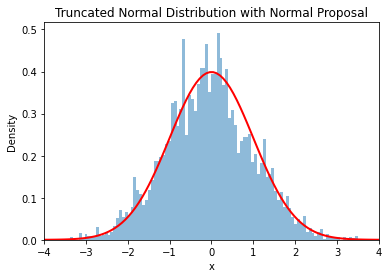

In [55]:
#Importing all the libraries
import numpy as np
from scipy.stats import norm

#Main function for generation of normal distribution using normal distribution but with different sigma
def truncated_normal_sampler(mu, sigma, rmin, rmax, n_samples, sigma_prop):
    #Target normal distribution
    def target_dist(x,sigma=sigma):
        if x < rmin or x > rmax: #To confirm that x is within truncated range
            return 0 #If not return 0
        else: 
            return norm.pdf(x, loc=mu, scale=sigma) #If within range return normal probability

    # Define the Normal proposal distribution for sampling
    def normal_proposal(x):
        return norm.rvs(loc=x, scale=sigma_prop)

    # Initialize the algorithm with a starting value within the truncated region
    x = np.random.uniform(low=rmin, high=rmax)
    samples = [x] #1st sample value is the random value generated form random uniform dist

    # Run the algorithm for a sufficient number of iterations to obtain an estimate of the target distribution
    for i in range(n_samples):
        # Generate a candidate sample from the Normal proposal
        x_prop = normal_proposal(x)

        # Calculate the acceptance probability
        acceptance_prob = (target_dist(x_prop)*target_dist(x,sigma_prop)) / (target_dist(x)*target_dist(x_prop,sigma_prop))

        # Generate a uniform random variable u between 0 and 1
        u = np.random.uniform()

        # If u <= acceptance_prob, accept the proposed sample and set x = x_prop.
        # Otherwise, reject the proposed sample and set x = x.
        if u <= acceptance_prob:
            x = x_prop

        samples.append(x)

    return samples

import matplotlib.pyplot as plt

# Set the parameters of the truncated Normal distribution and the Metropolis-Hastings sampler
mu = 0 #true mean of normal
sigma = 1 #True sigma
rmin = -4 # Trunction region
rmax = 4
n_samples = 10000 #number of samples to be evaluated
sigma_prop = 3 #sigma for the proposal function.

# Generate samples from the truncated Normal distribution using the Metropolis-Hastings sampler with a Normal proposal
samples = truncated_normal_sampler(mu, sigma, rmin, rmax, n_samples, sigma_prop)

# Plot the samples
plt.hist(samples, bins=100, density=True, alpha=0.5)
x = np.linspace(rmin, rmax, 100)
y = np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
plt.plot(x, y, 'r-', lw=2)
plt.xlim(rmin, rmax)
plt.xlabel('x')
plt.title('Truncated Normal Distribution with Normal Proposal')
plt.ylabel('Density')
plt.show()


In the above problem I encountered numerical problem where I am not sure of the cause. But if Acceptance ration = $ \frac{\pi(r^{prop})}{\pi(r^{old})} $ without the Q factor multiplied I obtained a much better result without any numerical error as shown below.

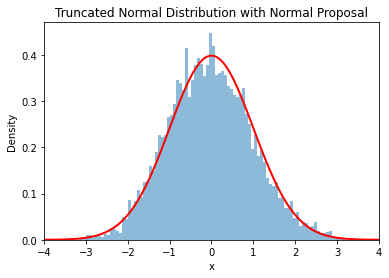

In [56]:
import numpy as np
from scipy.stats import norm

def truncated_normal_sampler(mu, sigma, rmin, rmax, n_samples, sigma_prop):
    # Define the target distribution and the truncated region
    def target_dist(x):
        if x < rmin or x > rmax:
            return 0
        else:
            return norm.pdf(x, loc=mu, scale=sigma) 

    # Define the Normal proposal distribution
    def normal_proposal(x):
        return norm.rvs(loc=x, scale=sigma_prop)

    # Initialize the algorithm with a starting value within the truncated region
    x = np.random.uniform(low=rmin, high=rmax)
    samples = [x]

    # Run the algorithm for a sufficient number of iterations to obtain an estimate of the target distribution
    for i in range(n_samples):
        # Generate a candidate sample from the Normal proposal
        x_prop = normal_proposal(x)

        # Calculate the acceptance probability (modified form)
        acceptance_prob = target_dist(x_prop) / target_dist(x)

        # Generate a uniform random variable u between 0 and 1
        u = np.random.uniform()

        # If u <= acceptance_prob, accept the proposed sample and set x = x_prop.
        # Otherwise, reject the proposed sample and set x = x.
        if u <= acceptance_prob:
            x = x_prop

        samples.append(x)

    return samples

import matplotlib.pyplot as plt

# Set the parameters of the truncated Normal distribution and the Metropolis-Hastings sampler
mu = 0
sigma = 1
rmin = -4
rmax = 4
n_samples = 10000
sigma_prop = 0.5

# Generate samples from the truncated Normal distribution using the Metropolis-Hastings sampler with a Normal proposal
samples = truncated_normal_sampler(mu, sigma, rmin, rmax, n_samples, sigma_prop)

# Plot the samples
plt.hist(samples, bins=100, density=True, alpha=0.5)
x = np.linspace(rmin, rmax, 100)
y = np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
plt.plot(x, y, 'r-', lw=2)
plt.xlim(rmin, rmax)
plt.xlabel('x')
plt.title('Truncated Normal Distribution with Normal Proposal')
plt.ylabel('Density')
plt.show()


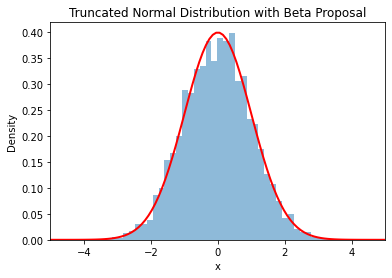

In [54]:
#Importing all the libraries
import numpy as np
from scipy.stats import norm, beta

#Main function for generating normal distribution with beta proposal
def truncated_normal_sampler_beta(mu, sigma, rmin, rmax, n_samples=1000, alpha_prop=2, beta_prop=2):
    """Metropolis-Hastings sampler for truncated Normal distribution with Beta proposal."""
    # Initialize sampler
    x = np.zeros(n_samples)
    x[0] = np.random.uniform(rmin, rmax)  # Start with a random value within the truncation bounds
    
    # Define target distribution function
    def target_dist(x):
        """Probability density function of truncated Normal distribution."""
        unnormalized_pdf = norm.pdf(x, loc=mu, scale=sigma) #generating normal probabilities
        normalization = norm.cdf(rmax, loc=mu, scale=sigma) - norm.cdf(rmin, loc=mu, scale=sigma) #normalizing factor
        return unnormalized_pdf / normalization if rmin <= x <= rmax else 0 #Making sure x is within range

    # Define Beta proposal distribution function
    def proposal_dist(x):
        """Probability density function of Beta proposal distribution."""
        a = (rmin - mu) / sigma #Translating and scaling the factors for the proposal to fall within range
        b = (rmax - mu) / sigma
        return beta.pdf((x - rmin) / (rmax - rmin), alpha_prop, beta_prop) / (rmax - rmin) #returning beta probabilities

    # Run sampler n_samples times
    for i in range(1, n_samples):
        # Generate proposed value from Beta distribution
        x_proposed = beta.rvs(alpha_prop, beta_prop) * (rmax - rmin) + rmin
        
        # Compute acceptance ratio
        acceptance_ratio = (target_dist(x_proposed) * proposal_dist(x[i-1])) / (target_dist(x[i-1]) * proposal_dist(x_proposed))
        
        # Accept or reject proposed value
        if np.random.uniform() < acceptance_ratio:
            x[i] = x_proposed
        else:
            x[i] = x[i-1]
    
    return x
# Define the parameters of the target distribution and the tuning parameters of the Beta proposal
mu = 0
sigma = 1
rmin = -5
rmax = 5
alpha_prop = 2
beta_prop = 2

# Generate samples from the truncated Normal distribution using the Metropolis-Hastings sampler with Beta proposal
samples = truncated_normal_sampler_beta(mu, sigma, rmin, rmax, n_samples=10000, alpha_prop=alpha_prop, beta_prop=beta_prop)

# Plot a histogram of the samples
x = np.linspace(rmin, rmax, 100)
y = np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi)) #Plot the original function as well.
plt.plot(x, y, 'r-', lw=2)
plt.hist(samples, bins=50, density=True, alpha=0.5, label='Metropolis-Hastings with Beta Proposal')
plt.xlim(rmin, rmax)
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Truncated Normal Distribution with Beta Proposal')
# plt.legend()
plt.show()

## Metropolis Cauchy Random Variable Sampler

Using the above code, by just changing the target distribution Cauchy sampler is generated.

Acceptance rate: 0.54


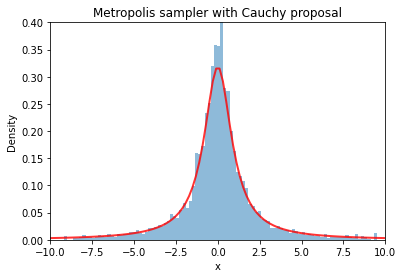

In [100]:
import numpy as np
from scipy.stats import beta,cauchy

def truncated_cauchy_sampler_beta(mu, sigma, rmin, rmax, n_samples=1000, alpha_prop=2, beta_prop=2):
    """Metropolis-Hastings sampler for truncated Normal distribution with Beta proposal."""
    # Initialize sampler
    x = np.zeros(n_samples)
    x[0] = np.random.uniform(rmin, rmax)  # Start with a random value within the truncation bounds
    accepted=0; #To calculate acceptance rate
    # Define target distribution function
    def target_dist(x):
        return cauchy.pdf(x)

    # Define Beta proposal distribution function
    def proposal_dist(x):
        """Probability density function of Beta proposal distribution."""
        a = (rmin - mu) / sigma
        b = (rmax - mu) / sigma
        return beta.pdf((x - rmin) / (rmax - rmin), alpha_prop, beta_prop) / (rmax - rmin)

    # Run sampler
    for i in range(1, n_samples):
        # Generate proposed value from Beta distribution
        x_proposed = beta.rvs(alpha_prop, beta_prop) * (rmax - rmin) + rmin
        
        # Compute acceptance ratio
        acceptance_ratio = (target_dist(x_proposed) * proposal_dist(x[i-1])) / (target_dist(x[i-1]) * proposal_dist(x_proposed))
        
        # Accept or reject proposed value
        if np.random.uniform() < acceptance_ratio:
            x[i] = x_proposed
            accepted += 1
        else:
            x[i] = x[i-1]
    print(f"Acceptance rate: {accepted/n_samples:.2f}")
    return x
# Define the parameters of the target distribution and the tuning parameters of the Beta proposal
mu = 0
sigma = 1
rmin = -10
rmax = 10
alpha_prop = 4
beta_prop = 4

# Generate samples from the truncated Normal distribution using the Metropolis-Hastings sampler with Beta proposal
samples = truncated_cauchy_sampler_beta(mu, sigma, rmin, rmax, n_samples=10000, alpha_prop=alpha_prop, beta_prop=beta_prop)

# Plot a histogram of the samples
plt.hist(samples, bins=100, density=True, alpha=0.5)
plt.xlim([rmin, rmax])
plt.ylim([0, 0.4])

# Plot true density function of Cauchy distribution
x = np.linspace(-10, 10, 100)
plt.plot(x, cauchy.pdf(x), 'r-', lw=2, alpha=0.8)

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Metropolis sampler with Cauchy proposal')
plt.show()

Using normal distribution and ignoring Q factors in the acceptance ratio gives us much better result than the previous case. With higher acceptance ratio.

Acceptance rate: 0.77


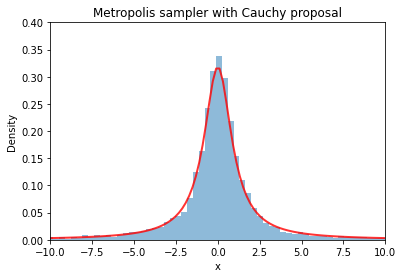

In [78]:
import numpy as np
from scipy.stats import cauchy,norm
import matplotlib.pyplot as plt

def cauchy_metropolis_normal(x0, n_samples, sigma_prop):
    # Define target distribution
    def target_dist(x):
        return cauchy.pdf(x)
    
    # Initialize sampler
    samples = np.zeros(n_samples)
    samples[0] = x0
    accepted = 0
    
    # Run sampler
    for i in range(1, n_samples):
        # Propose new sample from normal distribution
        x_proposed = np.random.normal(samples[i-1], sigma_prop)
        
        # Compute acceptance ratio
        acceptance_ratio = target_dist(x_proposed)/ target_dist(samples[i-1])
        
        # Accept or reject proposed sample
        if np.random.uniform() < acceptance_ratio:
            samples[i] = x_proposed
            accepted += 1
        else:
            samples[i] = samples[i-1]
    
    print(f"Acceptance rate: {accepted/n_samples:.2f}")
    return samples
x0 = 0
n_samples = 10000
sigma_prop = 1

samples = cauchy_metropolis_normal(x0, n_samples, sigma_prop)

plt.hist(samples, bins=100, density=True, alpha=0.5)
plt.xlim([-10, 10])
plt.ylim([0, 0.4])

# Plot true density function of Cauchy distribution
x = np.linspace(-10, 10, 100)
plt.plot(x, cauchy.pdf(x), 'r-', lw=2, alpha=0.8)

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Metropolis sampler with Cauchy proposal')
plt.show()

## Metropolis Laplace Sample generator
Tried to generate Laplace random number using beta proposal

  0%|          | 0/99999 [00:00<?, ?it/s]

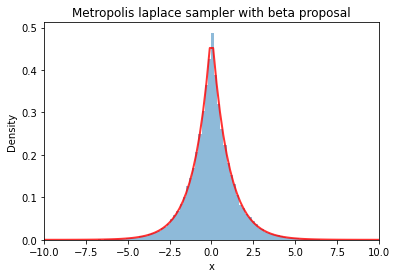

In [101]:
import numpy as np
from scipy.stats import beta,laplace
from tqdm.notebook import trange, tqdm

def truncated_laplace_sampler_beta(mu, b, rmin, rmax, n_samples=1000, alpha_prop=2, beta_prop=2):
    """Metropolis-Hastings sampler for truncated Normal distribution with Beta proposal."""
    # Initialize sampler
    x = np.zeros(n_samples)
    x[0] = np.random.uniform(rmin, rmax)  # Start with a random value within the truncation bounds
    
    # Define target distribution function
    def target_dist(x):
        return laplace.pdf(x,loc=mu,scale=b)

    # Define Beta proposal distribution function
    def proposal_dist(x):
        """Probability density function of Beta proposal distribution."""
        a = (rmin - mu) / sigma
        b = (rmax - mu) / sigma
        return beta.pdf((x - rmin) / (rmax - rmin), alpha_prop, beta_prop) / (rmax - rmin)

    # Run sampler
    for i in trange(1, n_samples):
        # Generate proposed value from Beta distribution
        x_proposed = beta.rvs(alpha_prop, beta_prop) * (rmax - rmin) + rmin
        
        # Compute acceptance ratio
        acceptance_ratio = (target_dist(x_proposed) * proposal_dist(x[i-1])) / (target_dist(x[i-1]) * proposal_dist(x_proposed))
        
        # Accept or reject proposed value
        if acceptance_ratio >= 1 or np.random.uniform() < acceptance_ratio:
            x[i] = x_proposed
        else:
            x[i] = x[i-1]
    return x
# Define the parameters of the target distribution and the tuning parameters of the Beta proposal
mu = 0
b = 1
rmin = -10
rmax = 10
alpha_prop = 4
beta_prop = 4

# Generate samples from the truncated Normal distribution using the Metropolis-Hastings sampler with Beta proposal
samples = truncated_laplace_sampler_beta(mu, b, rmin, rmax, n_samples=100000, alpha_prop=alpha_prop, beta_prop=beta_prop)

# Plot a histogram of the samples
plt.hist(samples, bins=100, density=True, alpha=0.5)
plt.xlim([rmin, rmax])

# Plot true density function of Cauchy distribution
x = np.linspace(-10, 10, 100)
plt.plot(x, laplace.pdf(x, mu, b), 'r-', lw=2, alpha=0.8)

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Metropolis laplace sampler with beta proposal')
plt.show()